In [1]:
# mounted to my drive so no need for manual authentication
# from google.colab import drive
# drive.mount('/content/drive')     

This is a project to verify that computer vision can be used as a suitable substitute to the induction coils installed under many traffic lights in Canada and United States. Given the limitations to real-time camera footage, a pre-recorded open-source video from Youtube is used to demonstrate the algorithm. Below is an image of the induction coils that detects up to 2 stationary for each lane.

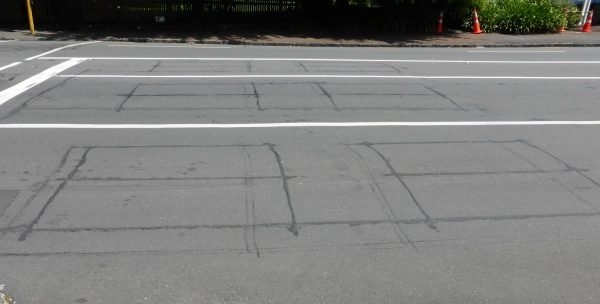

Below is a sample frame of what the machine vision algorithm is processing. Each car in the front n (in this case 3) rows are ID'd and timed independently. This process is is close to real time (120% of video time required) at 6 FPS and using Colab Free GPU, therefore algorithm should have no problem processing real-time footage with slightly lower FPS or with a decent processing unit.

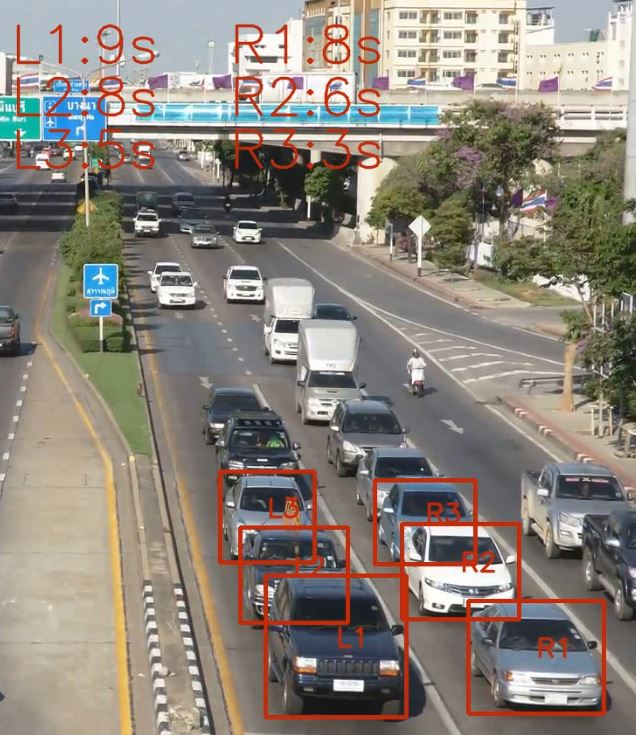

Install Detectron2

In [2]:
%%capture
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [4]:
%%capture
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Import trained model from directory

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # Set threshold for this model
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Scott_Portfolio/traffic_control/model_650.pth' # Set path model .pth
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
predictor = DefaultPredictor(cfg)

Support functions and custom class definition

In [6]:
class Vehicles:
  def __init__(self, code, center):
    self.code = code
    self.center = center
    self.motion = 0
    self.inframe = 0
    self.box = (0,0,0,0)
    self.buffer = [0,0,0,0]
    self.timer = 0
    self.last_motion = 0

class PS:
  def __init__(self, m1, b1, m2, b2, s):
    self.m1 = m1
    self.b1 = b1
    self.m2 = m2
    self.b2 = b2
    self.s = s

In [7]:
# drawing on frame support functions

def draw_traffic_light(im, motion):
  if motion:
    cv2.circle(im,(1790,150),50,green,-1)
  else:
    cv2.circle(im,(1790,150),50,red,-1)

def clear_frame(cars):
  # clear all cars from frame
  for car in cars:
    car.inframe = 0

def draw_backplate(im):
  border = 20
  cv2.rectangle(im, (1000-border,108-border), (1421+3*border,271+border), (50,50,50), -1)  #put backplate for interface for better view
  cv2.putText(im, 'TIMER', (1000-border,108-border-3), cv2.FONT_HERSHEY_SIMPLEX, 2,(50,50,50),3,cv2.LINE_AA)

def draw_car(im, cars, indent = 0):
  enter = 0
  for car in cars:
    if car.last_motion:
      colour = green
    else:
      colour = red
    cv2.putText(im, car.code + ':' + f'{int(car.timer)}s', (1000+indent, 150+enter), cv2.FONT_HERSHEY_SIMPLEX, 2,colour,2,cv2.LINE_AA)
    enter = enter + 60
    if car.inframe == 1:
      cv2.rectangle(im, (car.box[0], car.box[1]), (car.box[2], car.box[3]), colour, 3)
      timer = int(car.timer)
      cv2.putText(im, car.code,(car.center[0], car.center[1]), cv2.FONT_HERSHEY_SIMPLEX, 1,colour,2,cv2.LINE_AA)
      #cv2.putText(im, f'{int(car.motion)}',(car.center[0], car.center[1]), cv2.FONT_HERSHEY_SIMPLEX, 1,colour,2,cv2.LINE_AA)

In [8]:
# calculation support functions
def line_builder(p1, p2):
  #output format is based on x = my + b
  x1 = p1[0]
  y1 = p1[1]
  x2 = p2[0]
  y2 = p2[1]
  m = (x2-x1)/(y2-y1)
  b = x1-m*y1
  return m,b

def line_distance(m1,b1,m2,b2,y):
  x1 = m1*y + b1
  x2 = m2*y + b2
  return abs(x2-x1)

def area_triangle(p1, p2, p3):
  area = 0.5*(p1[0]*(p2[1]-p3[1])+p2[0]*(p3[1]-p1[1])+p3[0]*(p1[1]-p2[1]))
  return abs(area)

def inside_tetragon(pt, p1, p2, p3, p4):
  area_true = area_triangle(p1,p2,p3) + area_triangle(p1,p3,p4)
  area_point = area_triangle(pt, p1, p2) + area_triangle(pt, p2, p3) + area_triangle(pt, p3, p4) + area_triangle(pt, p4, p1)
  #print(area_triangle(pt, p1, p2),area_triangle(pt, p2, p3),area_triangle(pt, p3, p4),area_triangle(pt, p4, p1))
  #print("true=", area_true, "check=",area_point)
  if area_true < area_point:
    return False
  else:
    return True

def dis(l1, l2, ps):
  if l1[0] == -1 or l1[1] == -1:
    d = 9999   # return big distance for no detection
  else:
    d = pow(pow((l2[0]-l1[0]),2) + pow((l2[1]-l1[1]),2),0.5)   #consider signed differences?
    scaler = line_distance(ps.m1,ps.b1,ps.m2,ps.b2,(l1[1]+l2[1])/2)/ps.s
    d = d/scaler
    #print('d:',d,'h:',l2[1]-l1[1])
  return d

def min_ind(x):
  row_l = len(x[0])  
  ans = (int(x.argmin()/row_l), x.argmin()%row_l)
  return ans, x.min()



In [9]:
# update memory buffer for past motions and output current motion status
def buff_timer(buffer, movement, last_motion):
  # append 1 or 0 depending on motion
  if movement < thresh:
    buffer.append(0)
  else:
    buffer.append(1)
  n = len(buffer)
  move_count = 0
  motion = 0
  for x in buffer:
    if x == 1:
      move_count = move_count + 1
  if move_count/n > buff_thresh:
    motion = 1
  if n > buff_size: # limit buffer size
    buffer.pop(0)
  if motion == last_motion:
    return 0, motion # motion is consistent and timer continues
  else:
    return 1, motion  # motion has changed and timer restarts

# ID vehicles inside the region and extract features for tracking
def id_update(id_centers, id_boxes, cars, ps):
  i_n = len(id_centers)
  c_n = len(cars)
  d_mat = np.zeros((i_n,c_n))
  clear_frame(cars) # reset inframe variable
  for i in range(i_n):
    for c in range(c_n):
      d_mat[i][c] = dis(id_centers[i], cars[c].center, ps)
  for i in range(i_n):
    id, d = min_ind(d_mat)
    cars[id[1]].center = id_centers[id[0]]
    cars[id[1]].motion = d
    cars[id[1]].inframe = 1   # indicate that vehicle is in frame
    cars[id[1]].box = id_boxes[id[0]]
    #print(i,d_mat)
    for j in range(c_n):  # set matrix value to exclude selection
      d_mat[id[0]][j] = 9999
    for k in range(i_n):
      d_mat[k][id[1]] = 9999

# update the timer for each vehicle ID      
def timer_update(cars):
  for car in cars:
    flag, motion = buff_timer(car.buffer, car.motion, car.last_motion)
    car.last_motion = motion
    if flag or car.inframe == 0:
      car.timer = 0
    else:
      car.timer = car.timer + 1/30*fps_scale

# obtain the first n cars in each lane, currently set to 3
def car_tracking_n(car_centers, car_boxes, id, im, n):
  ans_id = []
  ans_center = []
  ans_boxes = []
  for j in range(n):
    max = 0
    flag = 0
    for i in id:
      if car_centers[i][1] > max:
        flag = 1
        max = car_centers[i][1]
        max_id = i
    if flag == 1:
      ans_id.append(max_id)    
      id.remove(max_id)

  # output proper centers and boxes as lists for further processing
  for idx in ans_id:
      #cv2.rectangle(im, (car_boxes[idx][0], car_boxes[idx][1]), (car_boxes[idx][2], car_boxes[idx][3]), red, 3)
      ans_center.append((car_centers[idx][0], car_centers[idx][1]))
      ans_boxes.append((car_boxes[idx][0], car_boxes[idx][1], car_boxes[idx][2], car_boxes[idx][3]))
  
  return ans_center, ans_boxes

In [65]:
def clip_predictor(im, clip):
  outputs = predictor(im[clip[0][0]:clip[1][0], clip[0][1]:clip[1][1]])
  car_centers = outputs["instances"].pred_boxes.get_centers().data.cpu().numpy()
  car_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  classes = outputs["instances"].pred_classes.cpu().numpy()
  for center in car_centers:
    center[0] = center[0] + clip[0][1]
    center[1] = center[1] + clip[0][0]
  for box in car_boxes:
    box[0] = box[0] + clip[0][1]
    box[2] = box[2] + clip[0][1]
    box[1] = box[1] + clip[0][0]
    box[3] = box[3] + clip[0][0]
  return car_centers, car_boxes, classes

# main function for processing the frame and Vehicle ID and motion tracking
def process_im_v2(im, cars1, cars2,n):
  #outputs = predictor(im)
  #car_centers = outputs["instances"].pred_boxes.get_centers().data.cpu().numpy()
  #car_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  #classes = outputs["instances"].pred_classes.cpu().numpy()
  car_centers, car_boxes, classes = clip_predictor(im, clip)
  # defining some local parameters
  wid = 4 
  # draw area of interest on frame
  #cv2.line(im,aoi[0],aoi[3],green,wid)
  #cv2.line(im,aoi[1],aoi[4],green,wid)
  #cv2.line(im,aoi[2],aoi[5],green,wid)
  #cv2.line(im,aoi[0],aoi[2],green,wid)

  # now we process the centers to only display the front row vehicles detected in the area of interest (two lanes on on-coming traffic)
  i = 0
  line1 = 0
  id1 = []
  line2 = 0
  id2 = []
  for center in car_centers:
    # check if center is in area1 or area2 and omit 'motorcycle' class
    # obtain index for each area, append to dynamic list
    if inside_tetragon(center, aoi[0], aoi[1], aoi[4], aoi[3]) is True and classes[i] == 0:
        id1.append(i)
    if inside_tetragon(center, aoi[1], aoi[2], aoi[5], aoi[4]) is True and classes[i] == 0:
        id2.append(i)
    i = i+1
  #print(id)
  
  # obtain center and boxes for first 3 vehicles
  car_center1, car_boxes1 = car_tracking_n(car_centers,car_boxes,id1,im,n)
  car_center2, car_boxes2 = car_tracking_n(car_centers,car_boxes,id2,im,n)
  id_update(car_center1, car_boxes1, cars1, ps1)
  id_update(car_center2, car_boxes2, cars2, ps2)
  timer_update(cars1)
  timer_update(cars2)
  draw_backplate(im)
  draw_car(im, cars1)
  draw_car(im, cars2, 250)
    #cv2.putText(im,'Car',(car_boxes[i][0], int(car_boxes[i][1]-6)), cv2.FONT_HERSHEY_SIMPLEX, 1,red,2,cv2.LINE_AA)
    #cv2.rectangle(im, (car_boxes[i][0], car_boxes[i][1]), (car_boxes[i][2], car_boxes[i][3]), red, 3)
    #cv2_imshow(im)
    # cv2.putText(im,"ticking",(300,400), cv2.FONT_HERSHEY_SIMPLEX, 3,red,2,cv2.LINE_AA)

  return im

Defining all of the global variables and processing parameters

In [68]:
aoi = [(1261,920), (1514,930), (1784,939),(1167,523),(1280,519),(1398,521)] #area of interest (in terms of detection and processing)
clip = [(400, 1100), (1050, 1900)]
a1, c1 = line_builder(aoi[0], aoi[3])   # equation representing 3 road lanes
a2, c2 = line_builder(aoi[1], aoi[4])
a3, c3 = line_builder(aoi[2], aoi[5])
s1 = line_distance(a1,c1,a2,c2,930)    # perspective scaling parameter
s2 = line_distance(a2,c2,a3,c3,930)
ps1 = PS(a1,c1,a2,c2,s1)
ps2 = PS(a2,c2,a3,c3,s2)
f_time = {0, 25, 57} # specific seconds when you want a picture to be exported to directory (for sample collection)
lane = [(-1,-1),(-1,-1)] # initialize some global variables
buff_thresh = 0.5 # buffer threshold
buff = [0]
fps_scale = 5
thresh = 6   # distance threshold
buff_size = int(30/fps_scale)
t = [0]
green = (0,131,81)
red = (16,30,187)
n_car = 3   # only this number of cars are timed in each lane
cars1 = [Vehicles('L1',aoi[4]), Vehicles('L2',aoi[4]), Vehicles('L3',aoi[4])] #initialize vehicle lists with custom class Vehicles
cars2 = [Vehicles('R1',aoi[4]), Vehicles('R2',aoi[4]), Vehicles('R3',aoi[4])]

Here we start processing the video, simulating processing real-time surveillance footage, output to output.mp4

In [69]:
%%time
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

cap = cv2.VideoCapture('/content/drive/MyDrive/Scott_Portfolio/traffic_control/traffic_long.mp4')


if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    res=(int(width), int(height))
    # this format fail to play in Chrome/Win10/Colab
    # fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
    # fourcc = cv2.VideoWriter_fourcc(*'H264') #codec
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('/content/drive/MyDrive/Scott_Portfolio/traffic_control/output_v2.mp4', fourcc, 30.0/fps_scale, res)

    frame = None
    frame_count = 0
    time = 0
    while (time < 60):
        time = int(frame_count/30)
        frame_count = frame_count + 1
        try:
            is_success, frame = cap.read()
        except cv2.error:
            continue

        if not is_success:
            break

        # if time in f_time:
        # if (time%2 == 0): #capture every 2 seconds
          # cv2.imwrite('/content/drive/MyDrive/Scott_Portfolio/traffic_control/frames/frame'+str(time)+"s.jpg", frame)
          # f_time.remove(time)

        # processing the image
        if (frame_count%fps_scale == 0):
          #print(time,t[-1])
          #image,lane = process_im(frame,lane,buff)
          image = process_im_v2(frame, cars1, cars2, n_car)
          out.write(frame)

    out.release() 

cap.release()

CPU times: user 1min 2s, sys: 7.25 s, total: 1min 9s
Wall time: 54.6 s
